# **Predicting Vehicles With tensorflow**

## **Import Libraries**

In [1]:
import os
import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from IPython.display import display, Javascript
from base64 import b64decode
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(resolver)
    print(f"Number of devices: {strategy.num_replicas_in_sync} TPU devices")
except:
    physical_devices = tf.config.list_physical_devices("GPU")
    if len(physical_devices) > 0:
        tf.config.set_visible_devices(physical_devices, "GPU")
        strategy = tf.distribute.MultiWorkerMirroredStrategy()
        print(f"Number of devices: {strategy.num_replicas_in_sync} GPU devices")
    else:
        strategy = tf.distribute.get_strategy()
        print(f"Number of devices: {strategy.num_replicas_in_sync} CPU devices")

Number of devices: 1 GPU devices


## **Load The Data**

In [3]:
try:
    from google.colab.output import eval_js
    if not os.path.exists("vehicles"):
        !git clone "https://github.com/denis-spe/vehicles"

    # Directory of dataset
    data_dir = "vehicles/vehicles"
except:
    # Directory of dataset
    data_dir = "vehicles"

Cloning into 'vehicles'...
remote: Enumerating objects: 132, done.
remote: Counting objects: 100% (132/132), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 132 (delta 25), reused 93 (delta 5), pack-reused 0
Receiving objects: 100% (132/132), 15.98 MiB | 15.92 MiB/s, done.
Resolving deltas: 100% (25/25), done.


In [4]:
# Seed for reproducible
seed = 123

# batch size
batch_size = 1 * strategy.num_replicas_in_sync

# image shape
img_height = 300
img_width = 300

train_ds = keras.utils.image_dataset_from_directory(
            data_dir,
            validation_split=0.2,
            subset="training",
            seed=seed,
            image_size=(img_width, img_height),
            batch_size=batch_size,
            label_mode='categorical'
        )

val_ds = keras.utils.image_dataset_from_directory(
            data_dir,
            validation_split=0.2,
            subset="validation",
            seed=seed,
            image_size=(img_width, img_height),
            batch_size=batch_size,
            label_mode='categorical'
        )

Found 196 files belonging to 4 classes.
Using 157 files for training.
Found 196 files belonging to 4 classes.
Using 39 files for validation.


# **Get To Know The Data**

In [5]:
classes = train_ds.class_names
classes

['bus', 'car', 'motorbike', 'truck']

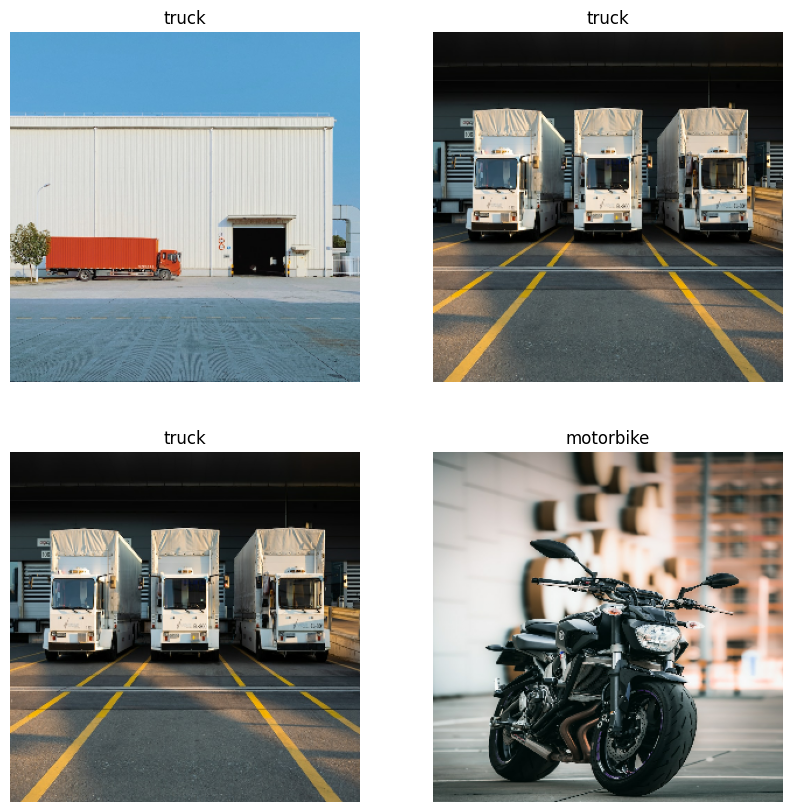

In [6]:
# Create a figure
fig = plt.figure(figsize=(10, 10))

# Number of rows and columns
NROW = 2
NCOL = 2

for i in range(NROW + NCOL):
    img, label = next(iter(train_ds.as_numpy_iterator()))

    fig.add_subplot(NROW, NCOL, i + 1)

    plt.imshow(tf.squeeze(img) / 255)
    plt.axis("off")
    plt.title(classes[tf.argmax(label[0]).numpy()])

In [7]:
img, label = next(iter(train_ds.as_numpy_iterator()))

In [8]:
img_shape = img.shape[1:]
img_shape

(300, 300, 3)

## **Model Building**

### **Callbacks**

In [9]:

# Instantiate the EarlyStopping object
early_stopping = keras.callbacks.EarlyStopping(
                    patience=2,
                    monitor='val_loss'
                   )

In [10]:
# Create callback list
callbacks = [
          early_stopping
       ]

### **Basic Model Building**

**Fit The Model**

In [11]:
with strategy.scope():
    # Input layer
    input_layer = layers.Input(img_shape)
    # Flatten the data
    flatten_layer = layers.Flatten()(input_layer)
    # Hidden layer One
    hidden_layer_1 = layers.Dense(1029, activation="relu")(flatten_layer)
    # output layer
    output_layer = layers.Dense(4, activation="softmax")(hidden_layer_1)

    # Instantiate the Model object
    model = keras.Model(input_layer, output_layer)

    # Print the model summary
    model.summary()

    # Compile the model
    model.compile(
        loss = "categorical_crossentropy",
        optimizer = keras.optimizers.Adam(),
        metrics = [
            keras.metrics.Accuracy()
        ]
    )

    # Fit the model
    model.fit(
        train_ds,
        epochs=500,
        validation_data=val_ds,
        batch_size=batch_size,
        callbacks = callbacks
    )

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 flatten (Flatten)           (None, 270000)            0         
                                                                 
 dense (Dense)               (None, 1029)              277831029 
                                                                 
 dense_1 (Dense)             (None, 4)                 4120      
                                                                 
Total params: 277835149 (1.04 GB)
Trainable params: 277835149 (1.04 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/500
157/157 [==============================] - 18s 87ms/step - loss: 96265.9922 - accuracy: 0.6752 - val_loss: 17486.9785 - val_accuracy: 0.820

**Save The Model**

In [12]:
model.save("model.keras")

**Load The Model**

In [13]:
saved_model = keras.models.load_model("model.keras")

**Evaluate The Model**

In [ ]:
saved_model.evaluate(val_ds)

**Predict The Image**

In [20]:
def predict_img(img):
    image = Image.open(img)
    resized_img = np.array(image.resize((300, 300)))

    # Expand image dimensions
    expand_dim_img = np.expand_dims(resized_img, axis=0)

    # Make prediction
    pred = saved_model.predict(expand_dim_img, verbose=0)

    # Model prediction probabilities
    probabilities = np.ceil(tf.nn.softmax(pred).numpy() * 100).astype("int")[0]

    # Select the classes by prediction as index
    label = classes[pred.argmax()]

    # Initializer the figure and axis
    fig, ax = plt.subplots(
        2, 1,
        figsize=(10, 10),
        constrained_layout=True,
        gridspec_kw={"height_ratios": [0.2, 2]}
    )

    # Plot bar
    bar = ax[0].bar(classes, probabilities, width=0.2)
    # Add the probabilities on the top of the bar plot
    ax[0].bar_label(bar, probabilities, size=18, weight=700)
    ax[0].set_title(label, weight=700, size=20)
    for side in ['top', 'right', 'left', 'bottom']:
        ax[0].spines[side].set_visible(False)
    ax[0].set_yticks([])

    # Plot the image
    ax[1].imshow(resized_img)
    ax[1].axis("off")
    plt.show()

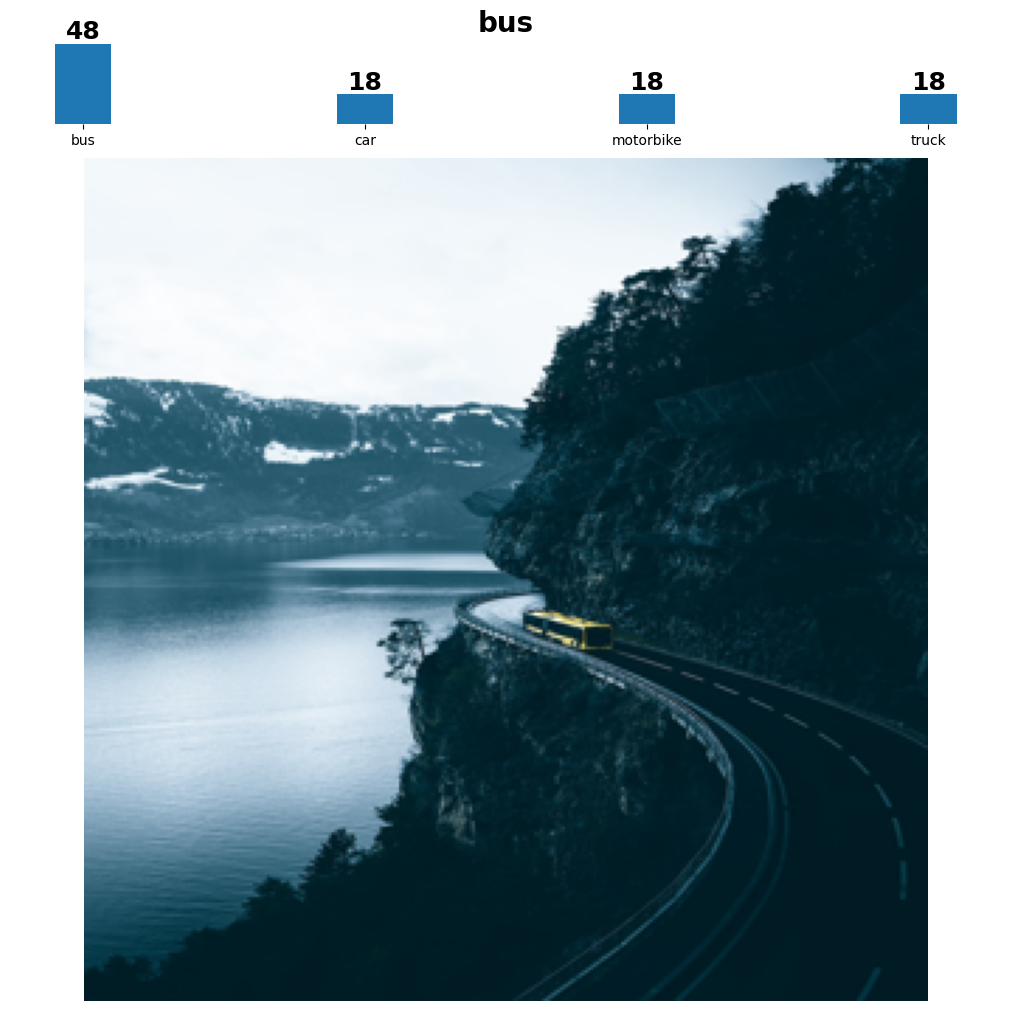

In [19]:

# Predict the image from train data
img = os.path.join(data_dir, "bus/img-102.jpeg")
predict_img(img)

In [17]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: {facingMode: 'environment'}});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

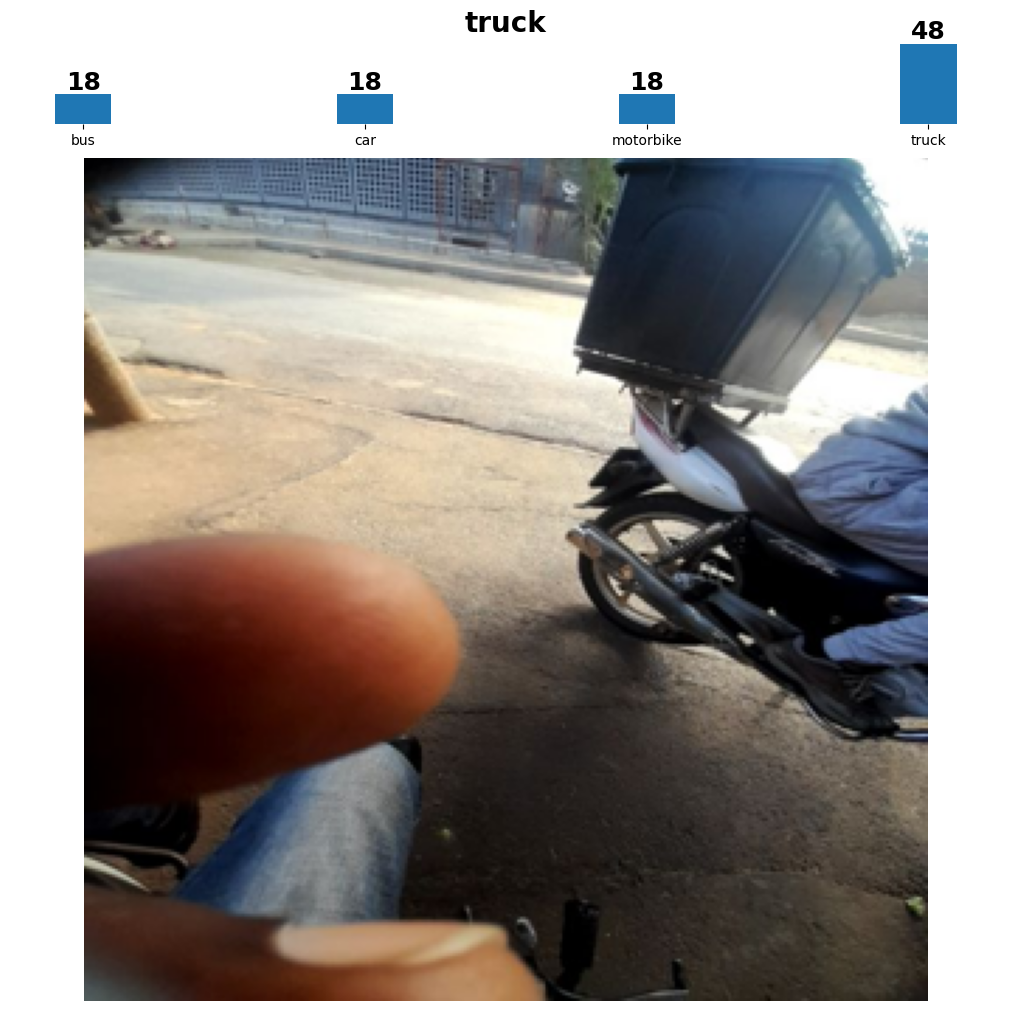

In [21]:
img = take_photo()
predict_img(img)